In [205]:
%run setup_Sv_compute.ipynb

# of files w/o bandwidth: 57
NB-VM-150         1088
OS-38              519
OS-75              363
WH-300             188
OS-150              26
NB-VM-300           25
NB-VM-75            14
BB-VM-150           13
OS-II-38             6
NB-DR-150            3
WH-Mariner-300       3
DCP4400A             1
WH-1200              1
OS-II-75             1
WH-Mariner-600       1
Name: instrument_name, dtype: int64


In [206]:
%run fxns_Sv_compute.ipynb

# Testing

### Calc Sv for one file

In [207]:
fname = '00890_short.nc' # --> Sv computation works for this! Uses OS, in central eq pac
#fname = '00111_short.nc' # --> Sv computation works for this! Uses NB-VM-150, in w eq pac
ncfile = dpath + 'JASADCP/ncfiles/' + fname
nc = xr.open_dataset(ncfile)

amp = nc['amp']
Tx = nc['tr_temp']
depth = nc['depth']
row = df[df['fname']==fname].iloc[0]
# - no bandwidth for a file; pretend it's narrowband for now
row['bandwidth']='narrowband'

Er = get_Er_constant(row,amp)
#print('Er: ',Er)

if 'NB' not in row['instrument_name']:
    Kc = get_Kc_constant(row)
elif 'NB' in row['instrument_name']:
    Kc = get_Kc_tdresolved(row,amp,Tx)
#print('Kc: ',Kc)

LDBM = get_LDBM_constant(row)
#print('LDBM: ',LDBM)

if 'NB' not in row['instrument_name']:
    PDBW = get_PDBW_constant(row)
elif 'NB' in row['instrument_name']:
    #PDBW = get_PDBW_tdresolved(row)
    PDBW = get_PDBW_constant(row)
#print('PDBW: ',PDBW)

R = get_R_tdresolved(row, depth, method_num=5)
#print('R: ',R)

c = calc_c_tdresolved(depth,T=25,S=35)
#print('c: ',c)

if 'NB' not in row['instrument_name']:
    C = get_C_constant(row)
elif 'NB' in row['instrument_name']:
    C = get_C_tdresolved(row,c)
#print('C: ',C)

Tnow = depth; Tnow.name = 'temperature'; Tnow[:,:] = 25
alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
#print('alpha: ',alpha)

alphaR = calc_alphaR_tdresolved(alpha,R)
#print('alphaR: ',alphaR)

Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
    + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


### Look at Sv for one file (check for UTC time)

In [208]:
import matplotlib.dates as mdates

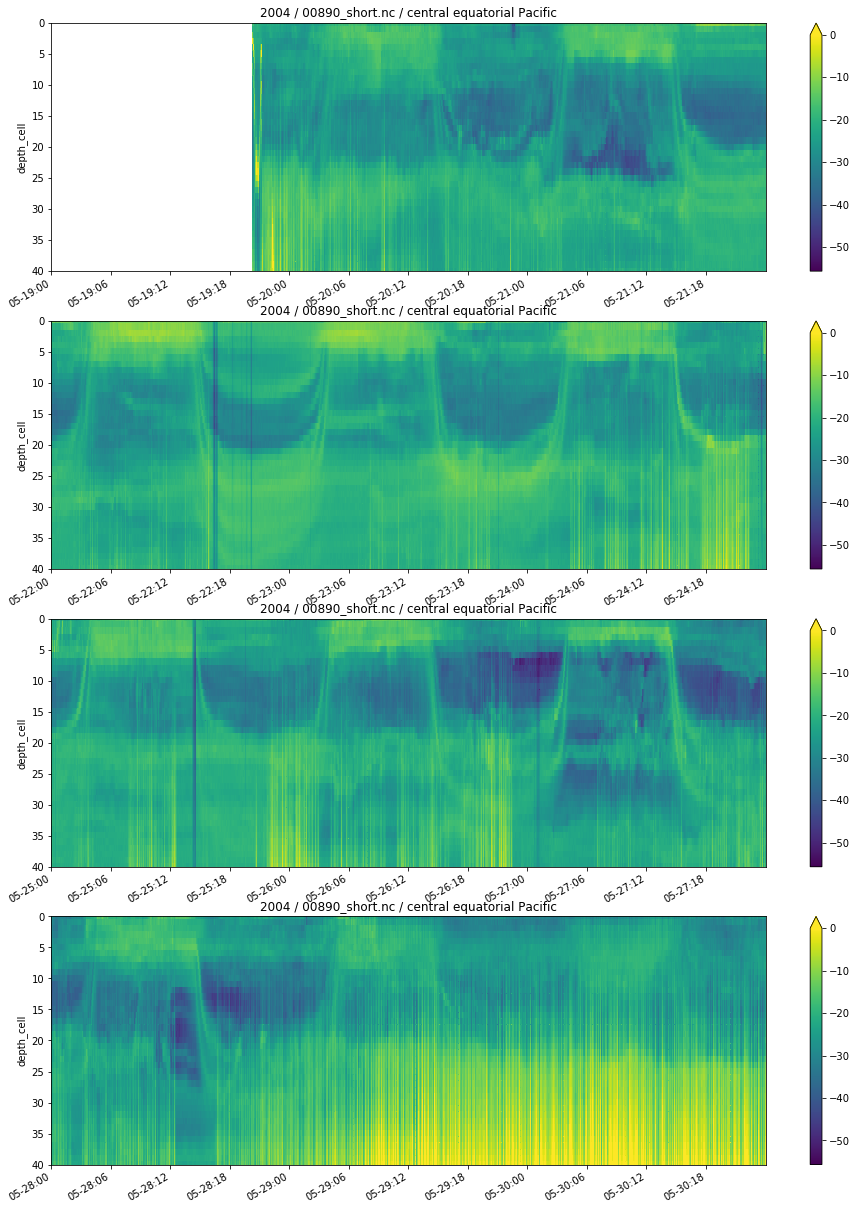

In [209]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

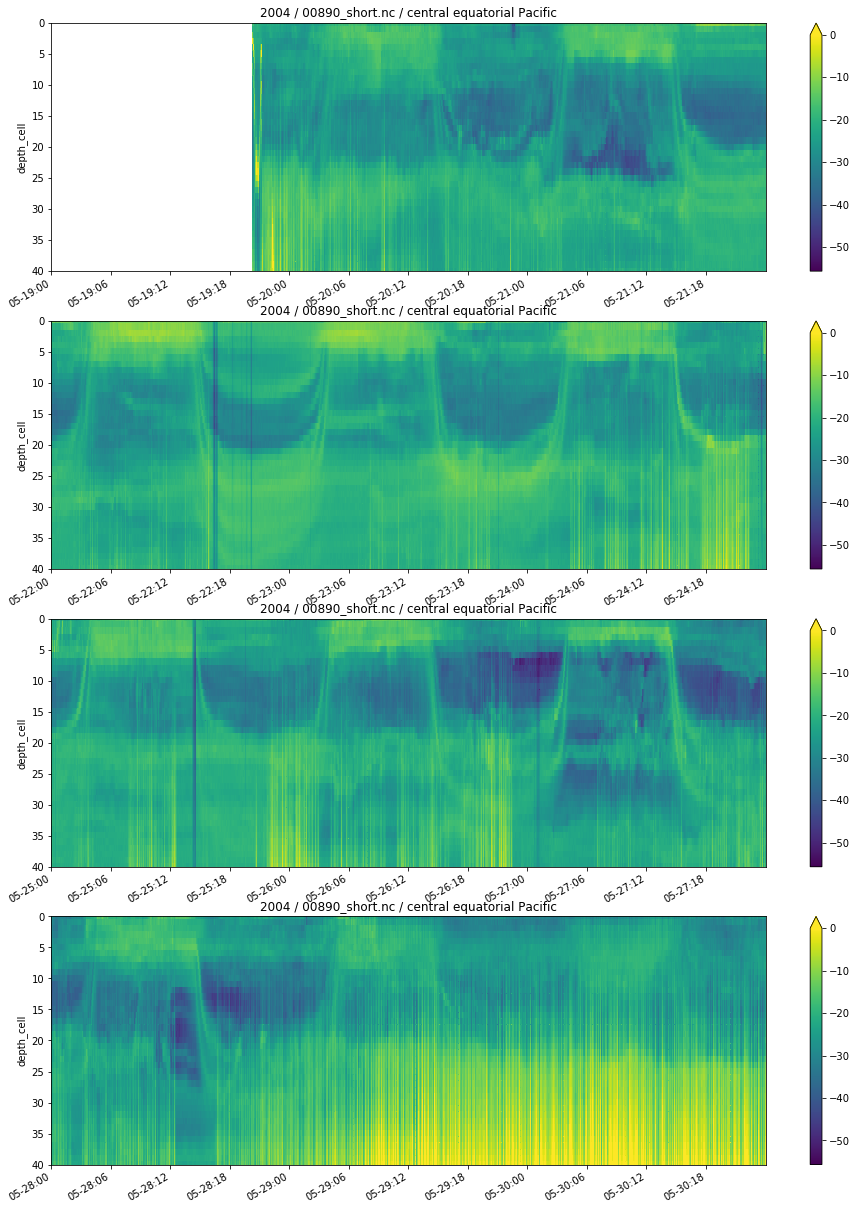

In [210]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Convert from UTC time to local time, re-look at Sv w/ local time, then compute day/night avg Sv like in Bianchi et al. (2013)

In [211]:
from datetime import datetime
from dateutil import tz
import pytz

In [212]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 1 (same as METHOD 2)
# https://stackoverflow.com/questions/4563272/convert-a-python-utc-datetime-to-a-local-datetime-using-only-python-standard-lib
# answer by Lennart Regebro
now = datetime.utcnow()
#HERE = tz.tzlocal()
HERE = tz.gettz('America/New_York')
UTC = tz.gettz('UTC')
gmt = now.replace(tzinfo=UTC)
test = gmt.astimezone(HERE)
print(test)
print(test.year)
print(test.hour)

2020-02-07 18:59:38.542049-05:00
2020
18


In [213]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 2 (same as METHOD 1)
# https://stackoverflow.com/questions/4770297/convert-utc-datetime-string-to-local-datetime
# USE 1: Hardcode zones:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')
# USE 2: Auto-detect zones:
#from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
# utc = datetime.utcnow()
utc = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
# Tell the datetime object that it's in UTC time zone since 
# datetime objects are 'naive' by default
utc = utc.replace(tzinfo=from_zone)
# Convert time zone
test = utc.astimezone(to_zone)
print(test)
print(test.year)
print(test.hour)

2011-01-20 21:37:21-05:00
2011
21


In [214]:
# - MY USE OF METHODS 1 AND 2
test = pd.to_datetime(Sv.time.values[0]).replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz('America/New_York'))
print(test)
print(test.year)
print(test.hour)

2004-05-19 16:22:29-04:00
2004
16


In [215]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 3
# https://stackoverflow.com/questions/25264811/pytz-converting-utc-and-timezone-to-local-time
pytz.utc.localize(datetime.utcnow()).astimezone(tz.gettz('America/New_York'))

datetime.datetime(2020, 2, 7, 18, 59, 38, 571070, tzinfo=tzfile('/usr/share/zoneinfo/America/New_York'))

In [216]:
# - MY USE OF METHOD 3
test = pytz.utc.localize(pd.to_datetime(Sv.time.values[0])).astimezone(tz.gettz('America/New_York'))
print(test)
print(test.year)
print(test.hour)

2004-05-19 16:22:29-04:00
2004
16


In [217]:
# - CONVERSION FROM UTC TO LOCAL TIME: METHOD 4
# https://stackoverflow.com/questions/25264811/pytz-converting-utc-and-timezone-to-local-time
# combines answers by N Randhawa and user8808265 
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
tznow = pytz.timezone('America/New_York')
tznow.fromutc(utc_time)

datetime.datetime(2011, 1, 20, 21, 37, 21, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)

In [218]:
# - MY USE OF METHOD 4
tznow = pytz.timezone('America/New_York')
test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
print(test)
print(test.year)
print(test.hour)

2004-05-19 16:22:29-04:00
2004
16


In [219]:
# - Now need to find time zone from lat/lon, then apply METHOD 4 above

# https://pypi.org/project/timezonefinder/
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
#print(timezonefinder.__file__)

latitude, longitude = 52.5061, 13.358
tzstr = tf.timezone_at(lng=longitude, lat=latitude) # returns 'Europe/Berlin'
tznow = pytz.timezone(tzstr)
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
#test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
test = tznow.fromutc(utc_time)
print(test)
print(test.year)
print(test.hour)

latitude, longitude = float(nc['lat'][0]), float(nc['lon'][0])
tzstr = tf.timezone_at(lng=longitude, lat=latitude)
print(tzstr)
tznow = pytz.timezone(tzstr)
utc_time = datetime.strptime('2011-01-21 02:37:21', '%Y-%m-%d %H:%M:%S')
#test = tznow.fromutc(pd.to_datetime(Sv.time.values[0]))
test = tznow.fromutc(utc_time)
print(test)
print(test.year)
print(test.hour)

2011-01-21 03:37:21+01:00
2011
3
Pacific/Marquesas
2011-01-20 17:07:21-09:30
2011
17


In [220]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 1
# (assuming timezone_at always works)
# --> sometimes timezone_at didn't work

local_time = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    tzstr_worked = tf.timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]))
    tznow = pytz.timezone(tzstr_worked)
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime]))
print(datetime.now().strftime("%H:%M:%S"))

23:59:38
23:59:44


In [221]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 2
# (using out of box timezonefinder package before DLing new ocn timezones geojson)
# --> sometimes even closest_timezone_at didn't work b/c middle of Pac ocean lol and you don't
# really wanna set the search radius to like 40 deg lol

local_time = [None]*len(Sv['time'])
print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    tzstr = tf.timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]))
    search_rad = 1
    while tzstr==None:
        tzstr = tf.closest_timezone_at(lng=float(nc['lon'][itime]), lat=float(nc['lat'][itime]), delta_degree=search_rad)
        search_rad += 1
    #print(itime, tzstr, search_rad)
    tznow = pytz.timezone(tzstr)
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime]))
print(datetime.now().strftime("%H:%M:%S"))

23:59:44
23:59:50


In [310]:
# - FINDING TIMEZONE FROM LAT/LON: METHOD 3
# https://timezonefinder.readthedocs.io/en/latest/2_use_cases.html 
# --> I did the procedure under "Use other data" section for getting better ocn timezone coverage
# By golly,  it was a nightmare/mess. Check Dockerfile for all the steps needed to make this work.
# But I think it works now! Either every ocn lat/lon has a timezone OR we deal with closest_timezone_at
# still not working by getting the last lat/lon timezone that worked. Since a cruise is a cruise (i.e.,
# you travel from one pt to another continuously and pts are all next to each other), this should be a good
# approximation. Plus, you can check it with local_time_flag and local_time_search_rad

local_time = [None]*len(Sv['time'])
local_time_flag = [None]*len(Sv['time'])
tz_search_rad = [None]*len(Sv['time'])
tz_name = [None]*len(Sv['time'])

print(datetime.now().strftime("%H:%M:%S"))
for itime in range(0,len(Sv['time'])):
    search_rad = 0
    lon = float(nc['lon'][itime])
    lat = float(nc['lat'][itime]) 
    try:
        tzstr_worked = tf.timezone_at(lng=lon, lat=lat)
        tznow = pytz.timezone(tzstr_worked)
    except: 
        tzstr = None
        search_rad = 1
        while tzstr is None:
            try:
                tzstr = tf.closest_timezone_at(lng=lon, lat=lat, delta_degree=search_rad)
            except: 
                if search_rad<5:
                    search_rad = search_rad + 1
                elif (search_rad>=5) & (search<=10):
                    search_rad = search_rad + 5
                elif search_rad>10:
                    # gets the last tzstr that worked
                    tzstr = tzstr_worked
                    local_time_flag[itime] = 'grabbed last working tz'
                pass
        tznow = pytz.timezone(tzstr)
    local_time[itime] = tznow.fromutc(pd.to_datetime(Sv.time.values[itime])).tz_localize(None)
    tz_name[itime] = tzstr
    tz_search_rad[itime] = search_rad
    #print(itime, tzstr, search_rad)
print(datetime.now().strftime("%H:%M:%S"))

00:35:12
00:35:18


In [247]:
ltnow = sorted(local_time)

In [248]:
ltnow==local_time

False

In [251]:
import operator

In [ ]:
map_object = map(operator.sub, ltnow, local_time)
subtracted_list = list(map_object)
print(subtracted_list)
#local_time-ltnow

In [262]:
sl = np.asarray([t.total_seconds() for t in subtracted_list])

In [276]:
sl[sl!=0]

array([ -299.,  -300.,  -599.,  -600.,  -898.,  -899., -1200., -1199.,
       -1499., -1500., -1801.,  1799.,  1500.,  1498.,  1202.,  1197.,
         901.,   899.,   600.,   599.,   298.,   301.,  -301.,  -299.,
        -600.,  -600.,  -901.,  -901., -1198., -1200., -1499., -1501.,
       -1800.,  1800.,  1499.,  1499.,  1202.,  1200.,   901.,   899.,
         600.,   600.,   299.,   301.])

In [277]:
sl!=0

array([False, False, False, ..., False, False, False])

In [289]:
np.where(sl!=0)

(array([2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318,
        2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329,
        3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442,
        3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453]),)

In [287]:
import itertools

In [305]:
ltprob = [ltnow[i] for i in list(itertools.chain(*np.where(sl!=0)))]
local_timeprob = [local_time[i] for i in list(itertools.chain(*np.where(sl!=0)))]
utc_timeprob = [Sv_orig['time'][i].values for i in list(itertools.chain(*np.where(sl!=0)))]

In [311]:
tz_nameprob = [tz_name[i] for i in list(itertools.chain(*np.where(sl!=0)))] 

In [337]:
dfprob = pd.concat([pd.Series(ltprob,name='ltprob'), pd.Series(local_timeprob,name='local_timeprob'),
                    pd.Series(utc_timeprob,name='utc_timeprob'), pd.Series(tz_nameprob,name='tz_nameprob'),
                    pd.Series(sl[sl!=0],name='sl')],axis=1)

In [338]:
dfprobno = pd.concat([pd.Series(ltnow,name='ltsort'), pd.Series(local_time,name='lt'),
                    pd.Series(Sv_orig['time'],name='utc'), pd.Series(tz_name,name='tz'),
                    pd.Series(sl,name='sl')],axis=1)

In [342]:
dfprobno['u-lt'] = dfprobno['utc']-dfprobno['lt']

In [346]:
dfprobno['lon'] = pd.Series(nc['lon'],name='lon')

In [347]:
dfprobno['lat'] = pd.Series(nc['lat'],name='lat')

In [333]:
tz_names = pd.Series(tz_name,name='tz_name')

In [334]:
tz_names[tz_names!='Pacific/Honolulu']

Series([], Name: tz_name, dtype: object)

In [348]:
dfprobno[2300:2308]

,ltsort,lt,utc,tz,sl,u-lt,lon,lat
2300,2004-05-27 11:03:15.000000000,2004-05-27 11:03:15.000000000,2004-05-27 20:03:15.000000000,Pacific/Honolulu,0.0,09:00:00,-142.243039,10.322117
2301,2004-05-27 11:08:16.000000000,2004-05-27 11:08:16.000000000,2004-05-27 20:08:16.000000000,Pacific/Honolulu,0.0,09:00:00,-142.257072,10.331889
2302,2004-05-27 11:13:14.000000002,2004-05-27 11:13:14.000000002,2004-05-27 20:13:14.000000002,Pacific/Honolulu,0.0,09:00:00,-142.270983,10.341392
2303,2004-05-27 11:18:15.000000000,2004-05-27 11:18:15.000000000,2004-05-27 20:18:15.000000000,Pacific/Honolulu,0.0,09:00:00,-142.284967,10.351158
2304,2004-05-27 11:23:16.000000000,2004-05-27 11:23:16.000000000,2004-05-27 20:23:16.000000000,Pacific/Honolulu,0.0,09:00:00,-142.299106,10.360928
2305,2004-05-27 11:28:14.000000000,2004-05-27 11:28:14.000000000,2004-05-27 20:28:14.000000000,Pacific/Honolulu,0.0,09:00:00,-142.313006,10.370603
2306,2004-05-27 11:33:14.999999998,2004-05-27 11:33:14.999999998,2004-05-27 20:33:14.999999998,Pacific/Honolulu,0.0,09:00:00,-142.327017,10.380103
2307,2004-05-27 11:38:16.000000000,2004-05-27 11:38:16.000000000,2004-05-27 20:38:16.000000000,Pacific/Honolulu,0.0,09:00:00,-142.341189,10.389617


In [349]:
dfprobno[sl!=0]

,ltsort,lt,utc,tz,sl,u-lt,lon,lat
2308,2004-05-27 11:38:16.000000000,2004-05-27 11:43:15.000000000,2004-05-27 20:43:15.000000000,Pacific/Honolulu,-299.0,09:00:00,-142.355067,10.398997
2309,2004-05-27 11:43:15.000000000,2004-05-27 11:48:15.000000000,2004-05-27 20:48:15.000000000,Pacific/Honolulu,-300.0,09:00:00,-142.368983,10.408417
2310,2004-05-27 11:43:17.000000000,2004-05-27 11:53:16.000000000,2004-05-27 20:53:16.000000000,Pacific/Honolulu,-599.0,09:00:00,-142.382925,10.417944
2311,2004-05-27 11:48:15.000000000,2004-05-27 11:58:15.000000000,2004-05-27 20:58:15.000000000,Pacific/Honolulu,-600.0,09:00:00,-142.396661,10.427242
2312,2004-05-27 11:48:18.000000002,2004-05-27 12:03:16.000000000,2004-05-27 21:03:16.000000000,Pacific/Honolulu,-898.0,09:00:00,-142.410692,10.436750
2313,2004-05-27 11:53:16.000000000,2004-05-27 12:08:15.000000000,2004-05-27 21:08:15.000000000,Pacific/Honolulu,-899.0,09:00:00,-142.424397,10.446022
2314,2004-05-27 11:53:16.000000000,2004-05-27 12:13:16.000000002,2004-05-27 21:13:16.000000002,Pacific/Honolulu,-1200.0,09:00:00,-142.438258,10.455369
2315,2004-05-27 11:58:15.000000000,2004-05-27 12:18:14.000000000,2004-05-27 21:18:14.000000000,Pacific/Honolulu,-1199.0,09:00:00,-142.451947,10.464642
2316,2004-05-27 11:58:17.000000000,2004-05-27 12:23:16.000000000,2004-05-27 21:23:16.000000000,Pacific/Honolulu,-1499.0,09:00:00,-142.465847,10.474033
2317,2004-05-27 12:03:16.000000000,2004-05-27 12:28:16.000000000,2004-05-27 21:28:16.000000000,Pacific/Honolulu,-1500.0,09:00:00,-142.479672,10.483417


In [224]:
# - Replot Sv w/ new local times
Sv_orig = Sv.copy(deep=True)

In [232]:
Sv_lt = Sv_orig.copy(deep=True)

In [ ]:
# - Do I just get floats (num of secs) if I remove time encoding?
Sv_exp = Sv_orig.copy(deep=True)
Sv_exp['time'].encoding = {}
Sv_exp['time']

In [235]:
Sv_lt['time'].values = local_time
Sv_lt['time']

<xarray.DataArray 'time' (time: 3502)>
array(['2004-05-19T10:52:29.000000000', '2004-05-19T10:57:29.000000000',
       '2004-05-19T11:02:28.999999998', ..., '2004-05-31T13:58:48.000000000',
       '2004-05-31T14:03:46.000000000', '2004-05-31T14:08:47.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2004-05-19T10:52:29 ... 2004-05-31T14:08:47
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    data_min:       139.84894675925926
    data_max:       152.00609953703704

In [236]:
# - Compare Sv_orig['time'] and Sv['time']
print(Sv_orig['time'][0])
print(Sv_orig['time'].attrs)
print(Sv_orig['time'].encoding)
print(Sv_lt['time'][0])
print(Sv_lt['time'].attrs)
print(Sv_lt['time'].encoding)

<xarray.DataArray 'time' ()>
array('2004-05-19T20:22:29.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2004-05-19T20:22:29
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    data_min:       139.84894675925926
    data_max:       152.00609953703704
OrderedDict([('long_name', 'Decimal day'), ('C_format', '%12.5f'), ('standard_name', 'time'), ('data_min', 139.84894675925926), ('data_max', 152.00609953703704)])
{'units': 'days since 2004-01-01 00:00:00', 'dtype': dtype('float64')}
<xarray.DataArray 'time' ()>
array('2004-05-19T10:52:29.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2004-05-19T10:52:29
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    data_min:       139.84894675925926
    data_max:       152.00609953703704
OrderedDict([('long_name', 'Decimal day'), ('C_format', '%12.5f'), ('standard_name', 'time'), ('data_min', 139.8

AttributeError: 'list' object has no attribute 'sorted'

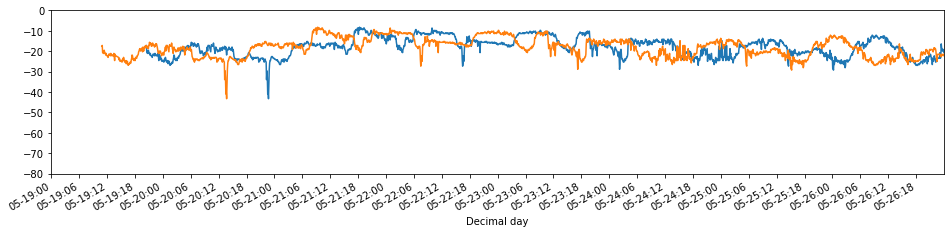

In [238]:
daynum = 19
fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
Sv_orig.isel(depth_cell=0).plot(ax=axes)
Sv_lt.isel(depth_cell=0).plot(ax=axes)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
axes.set_ylim([-80,0])
axes.set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+8)])
axes.set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+8), dtype='datetime64[h]')[0::6]);

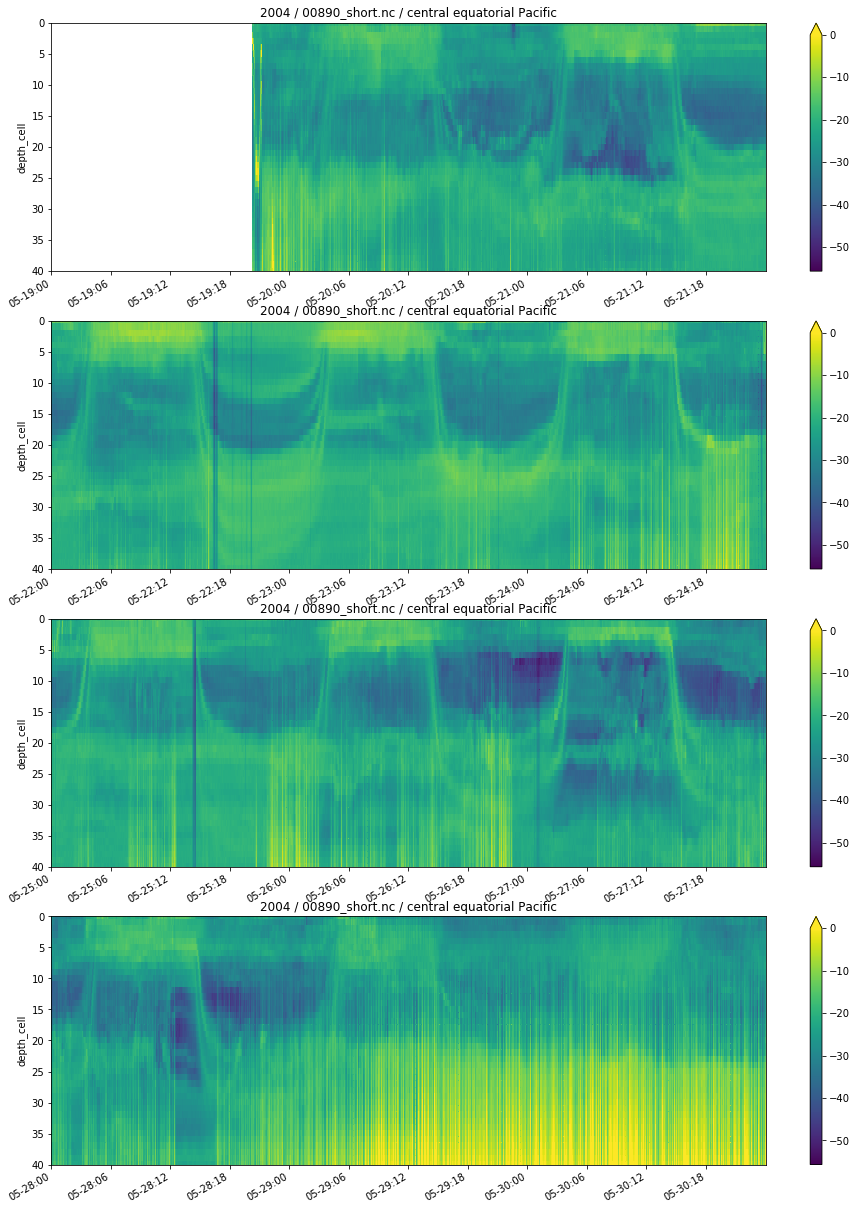

In [239]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

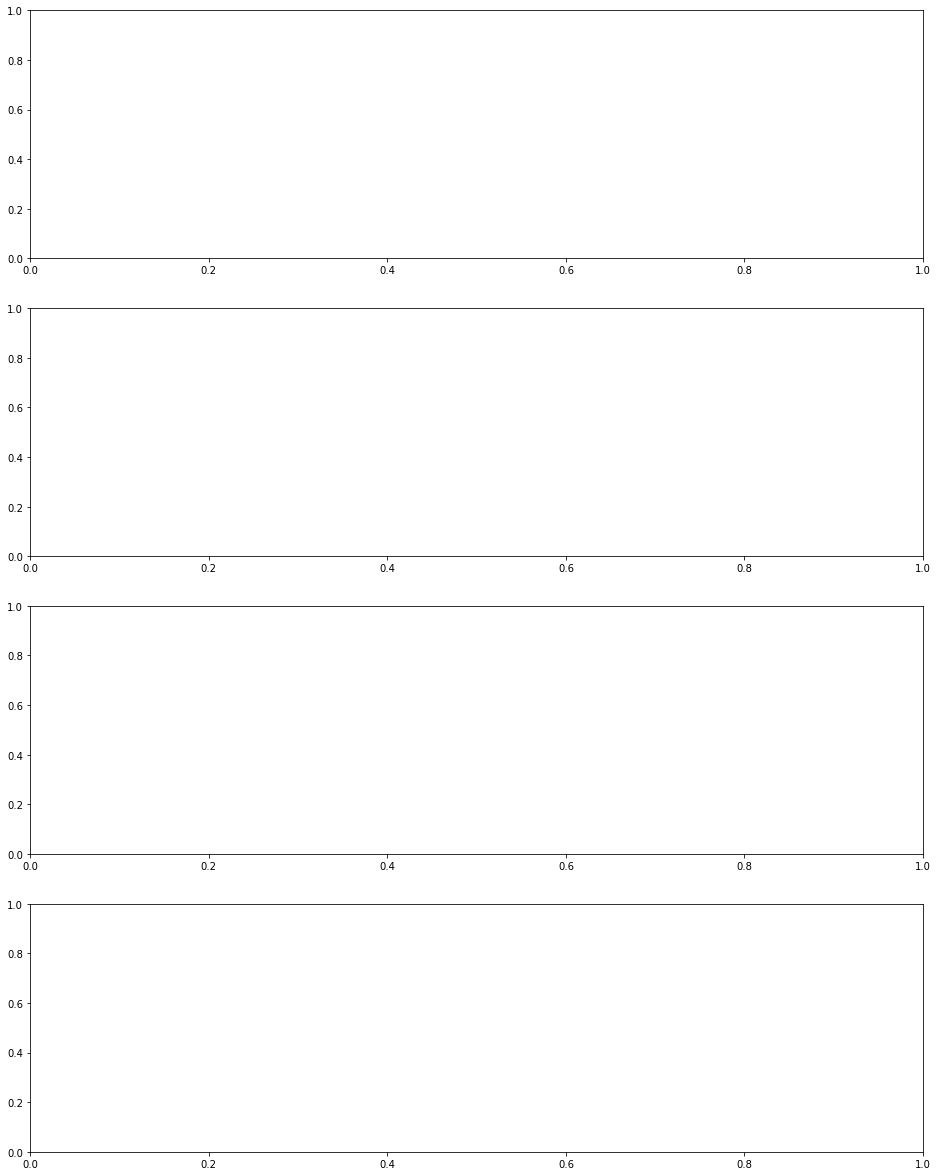

In [240]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv_lt.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Check all of the above for a 2nd file/cruise

In [ ]:
fname = '00890_short.nc' # --> Sv computation works for this! Uses OS, in central eq pac
#fname = '00111_short.nc' # --> Sv computation works for this! Uses NB-VM-150, in w eq pac
ncfile = dpath + 'JASADCP/ncfiles/' + fname
nc = xr.open_dataset(ncfile)

amp = nc['amp']
Tx = nc['tr_temp']
depth = nc['depth']
row = df[df['fname']==fname].iloc[0]
# - no bandwidth for a file; pretend it's narrowband for now
row['bandwidth']='narrowband'

Er = get_Er_constant(row,amp)
#print('Er: ',Er)

if 'NB' not in row['instrument_name']:
    Kc = get_Kc_constant(row)
elif 'NB' in row['instrument_name']:
    Kc = get_Kc_tdresolved(row,amp,Tx)
#print('Kc: ',Kc)

LDBM = get_LDBM_constant(row)
#print('LDBM: ',LDBM)

if 'NB' not in row['instrument_name']:
    PDBW = get_PDBW_constant(row)
elif 'NB' in row['instrument_name']:
    #PDBW = get_PDBW_tdresolved(row)
    PDBW = get_PDBW_constant(row)
#print('PDBW: ',PDBW)

R = get_R_tdresolved(row, depth, method_num=5)
#print('R: ',R)

c = calc_c_tdresolved(depth,T=25,S=35)
#print('c: ',c)

if 'NB' not in row['instrument_name']:
    C = get_C_constant(row)
elif 'NB' in row['instrument_name']:
    C = get_C_tdresolved(row,c)
#print('C: ',C)

Tnow = depth; Tnow.name = 'temperature'; Tnow[:,:] = 25
alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
#print('alpha: ',alpha)

alphaR = calc_alphaR_tdresolved(alpha,R)
#print('alphaR: ',alphaR)

Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
    + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)

In [ ]:
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(16,21))
daynum = 19
for isp in np.arange(0,4):
    Sv.plot(ax=axes[isp],y='depth_cell', vmax=0, yincrease=False)
    axes[isp].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    axes[isp].set_ylim([40,0])
    axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes[isp].set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes[isp].set_xlabel('')
    daynum = daynum + 3
#fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Compute Sv for all files assuming constant T, S, pH

In [ ]:
for fname in fnames:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)
    
    amp = nc['amp']
    Tx = nc['tr_temp']
    depth = nc['depth']
    row = df[df['fname']==fname].iloc[0]
    
    Er = get_Er_constant(row,amp)
    #print('Er: ',Er)
    
    if 'NB' not in row['instrument_name']:
        Kc = get_Kc_constant(row)
    elif 'NB' in row['instrument_name']:
        Kc = get_Kc_tdresolved(row,amp,Tx)
    #print('Kc: ',Kc)
    
    LDBM = get_LDBM_constant(row)
    #print('LDBM: ',LDBM)
    
    if 'NB' not in row['instrument_name']:
        PDBW = get_PDBW_constant(row)
    elif 'NB' in row['instrument_name']:
        #PDBW = get_PDBW_tdresolved(row)
        PDBW = get_PDBW_constant(row)
    #print('PDBW: ',PDBW)
    
    R = get_R_tdresolved(row, depth, method_num=5)
    #print('R: ',R)
    
    c = calc_c_tdresolved(depth,T=25,S=35)
    #print('c: ',c)
    
    if 'NB' not in row['instrument_name']:
        C = get_C_constant(row)
    elif 'NB' in row['instrument_name']:
        C = get_C_tdresolved(row,c)
    #print('C: ',C)
    
    Tnow = depth; Tnow.name = 'temperature'; Tnow[:,:] = 25
    alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
    #print('alpha: ',alpha)
    
    alphaR = calc_alphaR_tdresolved(alpha,R)
    #print('alphaR: ',alphaR)

    Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
        + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)

    # - CONTINUE HERE!!!
    # - ADD DANIELE ALGORITHM

From Bianchi et al. (2013) supplementary info:

"For each detectable DVM event (4640 in total) we estimated the daytime DVM depth from:
- (1) the maximum subsurface day-to-night echo intensity difference, and
- (2) the maximum subsurface daytime backscatter.

In the first case we calculated the difference in ADCP echo intensity averaged over a 3-hour interval centered at the time of maximum solar elevation (midday) and the ADCP echo intensity averaged over a 3-hour interval centered at the time of minimum solar elevation (midnight) for the nights surrounding the DVM event. We then detected the depth of the maximum subsurface echo intensity difference.

In the second case, we estimated the depth of the midday subsurface backscatter maximum. Backscatter was estimated from the ADCP echo intensity by correcting for both sound-wave spherical attenuation and water absorption using the formulation of [Deines, 1999]. The use of the two methods increased the number of records for which the daytime DVM depth could be isolated. Whenever both methods provided a valid daytime DVM depth, the average of the two values was taken."


# Load WOD data (T,S)

In [ ]:
def fxn(lon,lat,search_rad):
    try:
        tzstr = tf.closest_timezone_at(lng=lon, lat=lat, delta_degree=search_rad)
        return tzstr
    except:
        return search_rad+1

In [ ]:
result = None
while result is None:
    try:
        # connect
        result = get_data(...)
    except:
         pass